In [ ]:
# LightGBM and XGB for regression exercise
# author: Serigne
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

# Stacked Regressions to predict House Prices

In [355]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt # Matlab-style plotting
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

# avoid warning from sklearn and seaborn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
# limit float output
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p

## 1. Access and Explore Data

In [356]:
# load data
train = pd.read_csv('/Users/pliu/Downloads/all/train.csv')
test = pd.read_csv('/Users/pliu/Downloads/all/test.csv')

In [357]:
# check the dataset
train.shape # (1460, 81)
test.shape # (1459, 80)
train.head()
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [358]:
# save and drop the Id column from the dataset
train_ID, test_ID = train['Id'], test['Id']
train.drop('Id', inplace=True, axis=1)
test.drop('Id', inplace=True, axis=1)

In [359]:
test_ID.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

## 2. Data Processing

### 2.1 Outliers

In [360]:
def plot_scatter(col_1, col_2):
    fig, ax = plt.subplots()
    ax.scatter(x=train[col_1], y=train[col_2])
    plt.ylabel(col_2, fontsize=13)
    plt.xlabel(col_1, fontsize=13)
    plt.show()

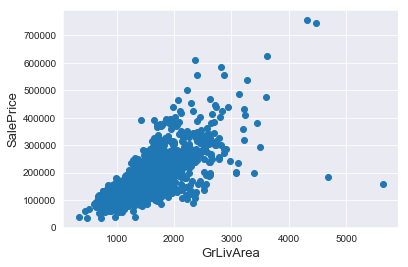

In [361]:
# GrLivArea: Above grade (ground) living area square feet
plot_scatter('GrLivArea', 'SalePrice')

In [362]:
# delete outliers
train.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<300000)].index,inplace=True)

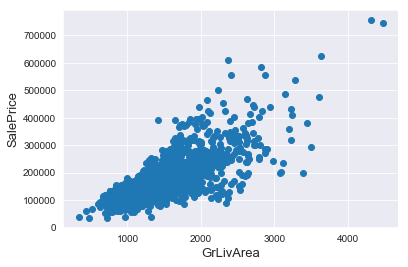

In [363]:
# check if outliers are removed
plot_scatter('GrLivArea', 'SalePrice')

### 2.2 Target Variable 

#### distribution of target variable

In [364]:
def distribution_plot(col, train=train):
    sns.distplot(train[col], fit=norm)
    # get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train[col])
    
    print('\n mu = {:.3f} and sigma = {:.3f}'.format(mu, sigma))
    # print ('\n mu = and sigma = '.format(mu, sigma))
    
    # now plot the distribution
    # add legend, label and title
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],loc='best')
    plt.ylabel('Frequency')
    plt.title(col + ' distribution')
    
    # Get also the QQ plot
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    plt.show()

/miniconda3/envs/ml36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180932.919 and sigma = 79467.789


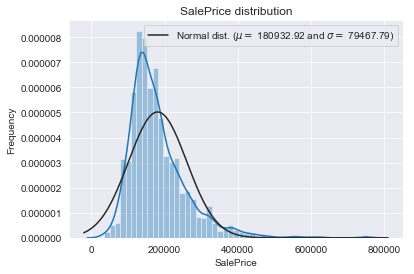

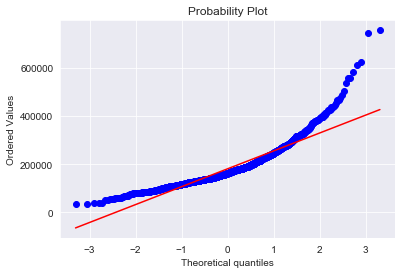

In [365]:
distribution_plot('SalePrice') # the target is right skewed

#### log transformation of target variable

In [366]:
# use numpy log1p to apply log(1+x) to all elements in the col
train['SalePrice'] = np.log1p(train['SalePrice'])


 mu = 12.024 and sigma = 0.400


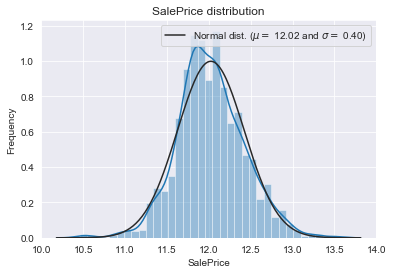

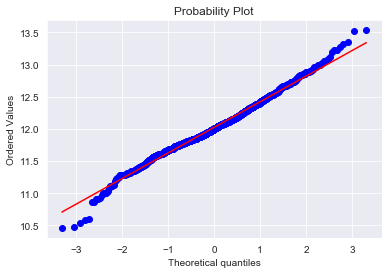

In [367]:
distribution_plot('SalePrice') # the target is right skewed

## 3. Feature Engineering

#### concatenate train and test

In [368]:
# stacking vertically
n_train, n_test = train.shape[0], test.shape[0]
# y_train = train.SalePrice # pandas.core.series.Series
y_train = train.SalePrice.values
type(y_train) #numpy.ndarray
all_data = pd.concat((train, test)).reset_index(drop=True)
# reset_index: after vertical concatenation, if you get an index of [0,n) by [0,m)
# all you need to do us call reset_index: pd.concat([a,b]).reset_index(drop=True)
all_data.drop('SalePrice', inplace=True, axis=1)
all_data.shape

(2917, 79)

In [370]:
n_train

1458

#### Missing Data

In [316]:
# Missing value statistics
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
type(all_data_na) # pandas.core.series.Series
# convert pandas.core.series.Series to pd.DataFrame
missing = pd.DataFrame({'Missing Ratio':all_data_na})
missing.head(20)

,Missing Ratio
PoolQC,99.69
MiscFeature,96.40
Alley,93.21
Fence,80.43
FireplaceQu,48.68
LotFrontage,16.66
GarageQual,5.45
GarageCond,5.45
GarageFinish,5.45
GarageYrBlt,5.45


In [317]:
# Missing Data Visualization
def missing_plot():
    f, ax = plt.subplots(figsize=(15, 12)) # set figure size
    plt.xticks(rotation='90') # x labels display vertically
    sns.barplot(x=all_data_na.index, y=all_data_na) # init a sns.barplot(x=, y=)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percentage of missing values', fontsize=15)
    plt.title('Percentage of missing data by feature', fontsize=15)

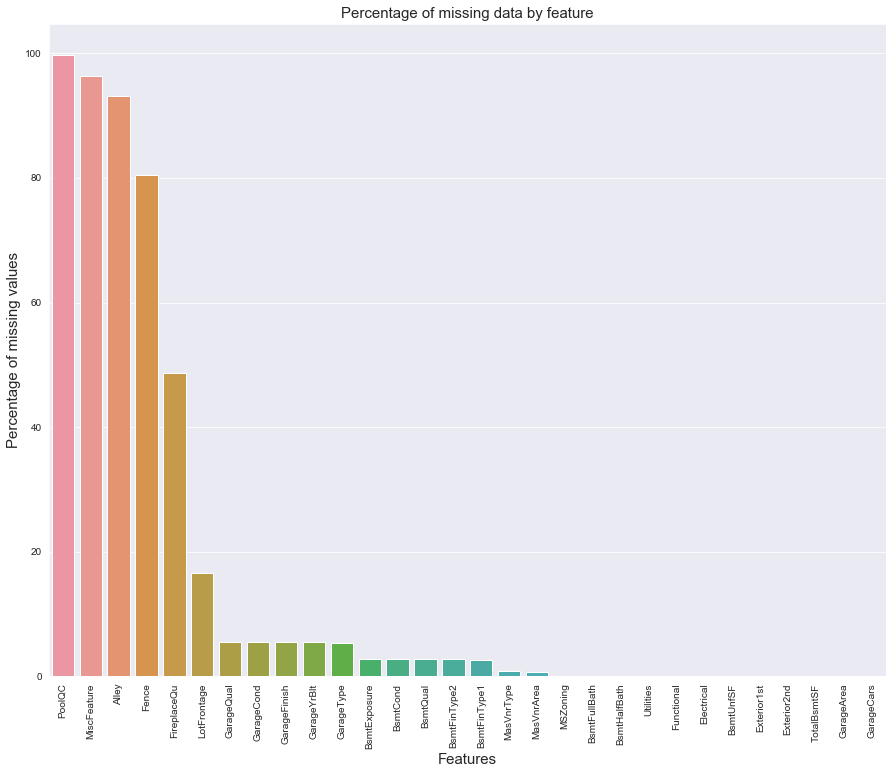

In [318]:
missing_plot()

#### Data Correlation

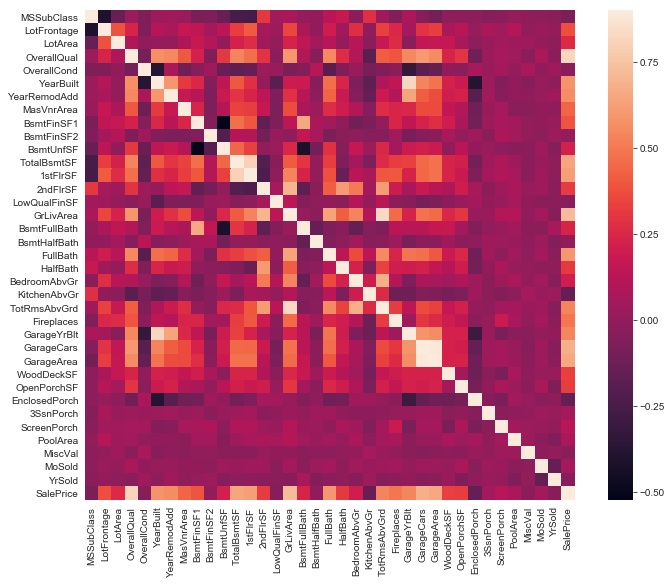

In [319]:
# correlation maps to see how features are correlated with target variables
# use df.corr and sns.heatmap
corrmat = train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### Inputting missing values


In [320]:
# input by 'None' according to description
by_None = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 
           'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
for col in by_None:
    all_data[col] = all_data[col].fillna('None')

In [321]:
# group by and input by median
# fillin missing values by the median of LotFrontage in the Neighborhood
# made a mistake here
#all_data['LotFrontage'] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median))
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [322]:
all_data.LotFrontage.dtypes

dtype('float64')

In [323]:
# replace by a number
by_Zero = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
           'BsmtFullBath', 'BsmtHalfBath']
for col in by_Zero:
    all_data[col] = all_data[col].fillna(0)

In [324]:
# replace by Mode
by_Mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MasVnrArea']

for col in by_Mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [325]:
# remove feature will not help in predicting
all_data.drop('Utilities', inplace=True, axis=1)

In [326]:
# others
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [327]:
# check remaining missing values
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
all_data_na

Series([], dtype: float64)

#### Other Feature Engineerings

#### Transform some numerical variables that are actually categorical

In [328]:
# MSSubClass: The building class
all_data['MSSubClass'].value_counts()

20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [329]:
# OverallCond: Overall condition rating
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [330]:
# YrSold: Year Sold
all_data['YrSold'].value_counts()

# Month Sold
all_data['MoSold'].value_counts()

# convert from int to str, for further encoding
for col in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']:
    all_data[col].astype(str)

In [331]:
# LabelEncoder assigns ordinal levels to categorical data
# test on sklearn.reprocessing.LabelEncoder

# LabelEncoder creates the ordering based on alphabetic ordering of the category
# this is inconsitant with intutaion:
# LabelEncoder's ording: Ex: 0, Gd: 2, TA: 4, Fa: 1, Po: 3
# ording that makes business sense: Ex: 4, Gd: 3, TA: 2, Fa: 1, Po: 0

test = pd.Series(['A', 'A', 'B', 'B', 'B', 'C', 'D', 'D', 'D'])
le = LabelEncoder()
print(le.fit_transform(test)) 

test2 = pd.Series(['A', 'A','D', 'D', 'D', 'B', 'B', 'B', 'C'])
le = LabelEncoder()
print(le.fit_transform(test2)) # still alphabetic ordering

[0 0 1 1 1 2 3 3 3]
[0 0 3 3 3 1 1 1 2]


In [332]:
# TODO
# process using pandas category
# df.feature = df.feature.astype('category', ordered=True, categories=['poor', 'average', 'good']).cat.codes

In [333]:
# use LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for col in cols:
    le = LabelEncoder()
    le.fit(list(all_data[col].values))
    all_data[col] = le.transform(list(all_data[col].values))

#### adding one more important feature

In [334]:
# adding total sq footage
all_data['total_sq'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### skewed features

In [335]:
# filter all numerical features
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index

# check the skew of all numerical features
skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skewed_features})
skewness.head()

,Skew
MiscVal,21.94
PoolArea,17.69
LotArea,13.11
LowQualFinSF,12.08
3SsnPorch,11.37



 mu = 2.089 and sigma = 34.555


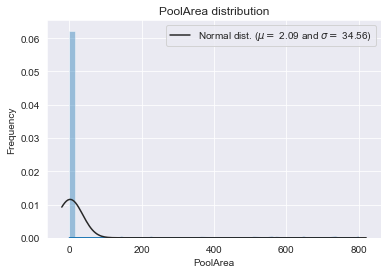

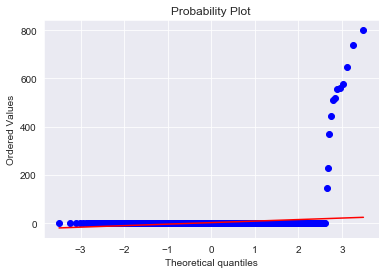

In [336]:
distribution_plot('PoolArea', all_data) # the target is right skewed

In [337]:
# Box Cox transformation for highly skewed features
skewness = skewness[abs(skewness.Skew) > 0.75]
# skewness = skewness[abs(skewness) > 0.75]
skewness.shape[0] # from 58 to 35

36

In [338]:
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


 mu = 0.038 and sigma = 0.171


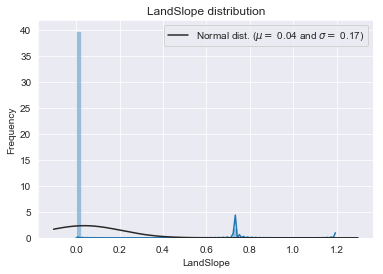

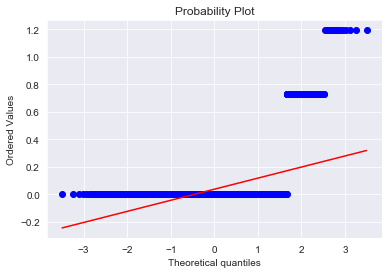

In [339]:
distribution_plot('LandSlope', all_data) # the target is right skewed

#### getting dummy variables

In [340]:
all_data.dtypes

1stFlrSF         float64
2ndFlrSF         float64
3SsnPorch        float64
Alley              int64
BedroomAbvGr       int64
BldgType          object
BsmtCond         float64
BsmtExposure     float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFinType1       int64
BsmtFinType2     float64
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtQual           int64
BsmtUnfSF        float64
CentralAir       float64
Condition1        object
Condition2        object
Electrical        object
EnclosedPorch    float64
ExterCond        float64
ExterQual        float64
Exterior1st       object
Exterior2nd       object
Fence            float64
FireplaceQu        int64
Fireplaces         int64
Foundation        object
FullBath           int64
                  ...   
LotFrontage      float64
LotShape           int64
LowQualFinSF     float64
MSSubClass         int64
MSZoning          object
MasVnrArea       float64
MasVnrType        object
MiscFeature       object
MiscVal          float64


In [344]:
#type(all_data)
sample = ['1stFlrSF','SaleType','ScreenPorch','Street','TotRmsAbvGrd']
tmp = pd.get_dummies(all_data)
#tmp = pd.get_dummies(all_data.iloc[:,49])
#all_data.columns[49]
#tmp.head()
#print(all_data.shape)
all_data.LotFrontage.describe() # LotFrontage       float
#all_data.dtypes # LotFrontage       object
#all_data.shape
#tmp.head()
all_data = pd.get_dummies(all_data)
all_data.shape # (2917, 220)

(2917, 220)

In [202]:
all_data.head()
# index df by col
# df1 = df.iloc[:,0:2]
# df1 = df[['a','b']]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,total_sq
0,11.69,11.69,0.00,1,3,1Fam,1.82,1.54,11.17,0.00,...,WD,0.00,0.73,8,856.00,0.00,2003,2003,2,14.98
1,12.79,0.00,0.00,1,3,1Fam,1.82,0.73,12.06,0.00,...,WD,0.00,0.73,6,1262.00,9.01,1976,1976,1,14.92
2,11.89,11.72,0.00,1,3,1Fam,1.82,1.19,10.20,0.00,...,WD,0.00,0.73,6,920.00,0.00,2001,2002,2,15.15
3,12.01,11.35,0.00,1,3,1Fam,0.73,1.54,8.27,0.00,...,WD,0.00,0.73,7,756.00,0.00,1915,1970,0,14.86
4,12.51,12.27,0.00,1,4,1Fam,1.82,0.00,10.97,0.00,...,WD,0.00,0.73,9,1145.00,8.01,2000,2000,2,15.85


In [371]:
# getting new train and test data
train, test = all_data[:n_train], all_data[n_train:]
test.shape

(1459, 79)

## 4. Modelling

### define a cross validation strategy

In [372]:
# use sklearn.model_selection.cross_val_score to evaluate a model performance in a CV manner
# cross_val_score: evaluate a score by cross-validation
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5
# func to calculate cross validation score
def rmsle_cv(model):
    
    # KFold: K-Folds cross-validator, providers train/test indices to split data in train/test sets
    # split dataset into k consecutive folds
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    
    # cross_val_score: evaluate a score by CV
    mse = -cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error', cv=kf)
    
    # RMSE
    rmse = np.sqrt(mse)
    return(rmse) # why with () ???

### Base Models

#### LASSO Regression

In [ ]:
from sklearn.pipeline import make_pipeline